## GenAI Stitching Project

### Import all libraries needed

In [302]:
import os
from dotenv import load_dotenv
import re
import json
import glob
from pathlib import Path
from typing import List
from typing_extensions import TypedDict
from pprint import pprint
import numpy as np
import pandas as pd
from pydantic import BaseModel, Field
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from fastembed import TextEmbedding
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display
from langchain_core.prompts import ChatPromptTemplate
from sentence_transformers import CrossEncoder
import streamlit as st
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel
import torch

### Load the API_KEY stored on .env

In [303]:
# call the .env for the stored api key
load_dotenv()
pinecone_api_key = os.getenv("PINECONE_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

# specify global k to find k nearest vector on the vector db
k = 5

### Data Loading for RAGs

In [304]:
news_data = []

# reading all of the 1000 news data
for i in range(1, 1001):
    filename = Path('finance_news') / f'article_{i}.json'
    with open(filename, 'r', encoding = 'utf-8') as f:
        data = json.load(f)
        news_data.append({
                'title': data.get('title', ''),
                'text': data.get('text', ''),
                'published': data.get('published', ''),
                'author': data.get('author', ''),
                'url': data.get('url', '')
        })

df = pd.DataFrame(news_data)

def clean_text(text):
    text = ' '.join(text.lower().split())
    return text

# Create a mask for unique texts
text_mask = ~df['text'].apply(clean_text).duplicated()

# Apply the mask to get unique articles only
df = df[text_mask]
df = df.reset_index(drop=True)  # Reset index after filtering

# split the text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500, # every chunk will contains maximum of 500 characters
    chunk_overlap = 50, # overlapping 50 characters between chunks
    separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""] # prioritize paragraph breaks, line breaks, sentence (., !, ?), etc.
)

# apply the text_splitted, make sure it is non empty text
df["chunk"] = df["text"].apply(lambda x: text_splitter.split_text(x) if isinstance(x, str) and x.strip() else [])

# clean the chunk. just noticed after finding the nearest k query
def clean_chunk(chunk):
    chunk = chunk.strip()  # remove trailing spaces
    chunk = re.sub(r"^[^\w]+", "", chunk)  # remove leading non-word characters (., -, etc.)
    return chunk

# apply cleaning to each chunk
df["chunk"] = df["chunk"].apply(lambda chunks: [clean_chunk(chunk) for chunk in chunks])

### Upload to Pinecone DB

In [305]:
# make it into one list before embedding the data
all_chunks = []
for i in range(len(df)):
    all_chunks.extend(df['chunk'].iloc[i])

embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
embeddings = embedding_model.embed_documents(all_chunks)

# input the API key and also the created index in pinecone
pc = Pinecone(api_key=pinecone_api_key)

index_name = 'finance-news'

# if the index name exist already, delete it first
existing_indexes = [index['name'] for index in pc.list_indexes()]
if index_name in existing_indexes:
   pc.delete_index(index_name)

# create the index for the data to be stored in vector db
pc.create_index(
    name = index_name,
    dimension=384,
    metric="cosine",
    spec={
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    }
)
index = pc.Index(index_name)

vectors_to_upload = []
chunk_index = 0

for idx, row in df.iterrows():
    chunks = row['chunk']
    for chunk_num, chunk in enumerate(chunks):
        vector = embeddings[chunk_index]
        
        metadata = {
            "raw_text_index": str(chunk_index),  # Store chunk-level index
            "article_index": str(idx)  # Store article index for reference
        }
        
        vectors_to_upload.append((str(chunk_index), vector, metadata))
        chunk_index += 1

# uploading to pinecone by batch_size because the data is too large
batch_size = 100
for i in range(0, len(vectors_to_upload), batch_size):
    batch = vectors_to_upload[i:i + batch_size]
    index.upsert(vectors=batch)

### Basic RAGs

In [306]:
# set the OpenAI API key
os.environ["OPENAI_API_KEY"] = openai_api_key

# initialize OpenAI LLM, use 4o mini because here i'm using updated news
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [307]:
# create a template for the prompt. rlm/rag-prompt is the prompt for RAG in Langchain.
# this will control how the final input is structured for the LLM
template_prompt = hub.pull("rlm/rag-prompt")

# create a vectorestore to store the vector database from pinecone. text_fields means the original text stored on the vector db
text_field = "raw_text_index"
vectorstore = PineconeVectorStore(  
    index, embedding_model, text_field
)

# split into list. this splits will be used for the retrieval
splits = df["chunk"].explode().tolist() 

# format docs is used to make sure that each document that is fitted to the RAG is cleaned with the same format
def format_docs(docs):
    if isinstance(docs, list):
        docs = [str(doc) for doc in docs]  # make sure all elements are string
    elif isinstance(docs, dict):
        docs = [json.dumps(docs)]  # converting dictionary to string for debugging
    else:
        docs = [str(docs)]  # convert any type to string

    return "\n\n".join(docs)

# create custom retriever
class CustomRetriever(BaseRetriever):
    vectorstore: PineconeVectorStore
    splits: List

    def _get_relevant_documents(self, query):
        # Handle different query types
        if isinstance(query, dict):
            # Extract query from dictionary if present, otherwise convert to string
            query_text = query.get("question", str(query))
        else:
            query_text = str(query)
            
        # Perform vector search with the text query
        docs = self.vectorstore.similarity_search(query_text, k=k)
        
        # Fetch raw text
        outputs = []
        for doc in docs:
            raw_text = self.splits[int(doc.id)]
            outputs.append(raw_text)
        return outputs
    
# retrieve the most similar vector db in pinecone and it will map the id of the splits
retriever = CustomRetriever(vectorstore=vectorstore, splits=splits)

# Define a preprocessing function to ensure we handle the input correctly
def preprocess_query(query_input):
    if isinstance(query_input, dict):
        return query_input.get("question", "")
    return query_input

system = """You are a financial information assistant. Provide direct answers based on the documents provided.
Answer briefly and straightforwardly using only the information in the documents."""

template_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "Question: {question}\n\nRelevant documents: {context}")
])

# flow -> retrieve the most similar vector db, map on the id of the splits, then format the documents because the docs are still unstructured
# then pass the original question, the template prompt will help us to structure the format so that the LLM will understand the context
rag_chain = (
    {
        "context": retriever | (lambda docs: format_docs(docs)), 
        "question": RunnablePassthrough() | (lambda q: preprocess_query(q))
    }
    | template_prompt
    | llm
    | StrOutputParser()
)

/opt/anaconda3/lib/python3.12/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### Import the fine-tuned model from assignment 3

In [308]:
base_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
summarizer_model = PeftModel.from_pretrained(base_model, "lora_adapters")
summarizer_tokenizer = AutoTokenizer.from_pretrained("lora_adapters")

In [309]:
summarizer_model.eval()

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 512)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 512)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=512, out_features=512, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=512, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=512, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
              

### Agent that scores if a retrieved document is relevant to the question

In [310]:
# Data model
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments,method="function_calling")

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

### Agent that checks if the RAG output hallucinates

In [311]:
### Hallucination Grader
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations,method="function_calling")

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

### Agent that checks if RAG output answers the question

In [312]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer,method="function_calling")

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

### Agent that re-writes the query used for retrieval

In [313]:
### Question Re-writer
# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

### LangGraph Strucuture

In [314]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        summarized: summary of the generation
        summarized_docs: summary of the docs before generation
    """

    question: str
    generation: str
    documents: List[str]
    summarized: str
    summarized_docs: List[str]

In [353]:
### Nodes
def retrieve(state):
    # print("---Retrieve Documents---")
    question = state["question"]

    # retrieve the question and get the documents
    documents = retriever.invoke(question)

    # used for debugging problem
    # print("Question:", question)
    # print("Documents:", documents)

    # return documents and question
    return {"documents": documents, "question": question}

def generate(state):
    # print("---Generate Answer---")
    # get the documents retrieved and the question
    question = state["question"]
    documents = state["documents"]

    formatted_docs = format_docs(documents)

    advanced_prompt = f"""You are an advanced analytical assistant specializing in financial markets and business news.
        Question: {question}
        Relevant documents: {formatted_docs}
        Instructions:
        1. Extract and explain specific details from the documents provided.
        2. Focus only on exact information from the documents. Do not summarize or paraphrase.
        3. Instead, identify and extract specific facts, numbers, dates, and direct quotes.
        4. If asked for implications or analysis, only include those explicitly stated in the documents.
        """
    
    generation = llm.invoke(advanced_prompt)

    # used for debugging problem
    # print("Generated Anser:", generation)
    # return the docs, question, and generation answer
    return {"documents": documents, "question": question, "generation": generation.content}

## this is the node for last summary after generating the answer
def summary(state):
    # print("---Summarize Generated Answer---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    inputs = summarizer_tokenizer(generation, return_tensors="pt", max_length=1024, truncation=True)
    with torch.no_grad():
        summary_ids = summarizer_model.generate(
            input_ids=inputs["input_ids"], 
            max_length=150,
            min_length=40,
            num_beams=4
        )
    summarized_generation = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return {"documents": documents, "question": question, "generation": generation, "summarized": summarized_generation}

## here i try to create another ai agent where it summarize the documents first. it might help on generating more concise answer
def summarize_documents(state):
    # print("---Summarize Retrieved Documents---")
    question = state["question"]
    documents = state["documents"]
    # print(documents)
    
    summarized_docs = []
    for doc in documents:
        # Clean up links and URLs from the original document first
        cleaned_doc = re.sub(r'\[.*?\]\(.*?\)', '', doc)  # Remove markdown links
        cleaned_doc = re.sub(r'http[s]?://\S+', '', cleaned_doc)  # Remove URLs
        cleaned_doc = re.sub(r'\(\s*http[s]?://\S+\s*\)', '', cleaned_doc)  # Remove parenthesized URLs
        cleaned_doc = re.sub(r'www\.\S+', '', cleaned_doc)  # Remove www URLs
        cleaned_doc = re.sub(r'\s+', ' ', cleaned_doc)  # Clean up extra whitespace
        cleaned_doc = cleaned_doc.strip()  # Remove leading/trailing whitespace
        
        # Now summarize the cleaned document
        inputs = summarizer_tokenizer(cleaned_doc, return_tensors="pt", max_length=1024, truncation=True)
        with torch.no_grad():
            summary_ids = summarizer_model.generate(
                input_ids=inputs["input_ids"],
                max_length=150,
                min_length=40,
                num_beams=4
            )
        summary = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        
        summarized_docs.append(summary)
    
    return {"documents": documents, "summarized_docs": summarized_docs, "question": question}

def generate_with_summarized_docs(state):
    # print("---Generate Answer From Summarized Docs---")
    # Get the question and summarized documents
    question = state["question"]
    summarized_docs = state["summarized_docs"]
    documents = state["documents"]
    
    # for i, doc in enumerate(summarized_docs):
    #     print(f"Summarized Doc #{i+1} (first 100 chars): {doc[:100]}...")
    
    formatted_docs = format_docs(summarized_docs)

    advanced_prompt = f"""You are an advanced analytical assistant specializing in financial markets and business news.
        Question: {question}
        Relevant documents: {formatted_docs}
        Instructions:
        1. Extract and explain specific details from the documents provided.
        2. Focus only on exact information from the documents. Do not summarize or paraphrase.
        3. Instead, identify and extract specific facts, numbers, dates, and direct quotes.
        4. If asked for implications or analysis, only include those explicitly stated in the documents.
        5. No need to give the summary of the whole context.
        """
    
    generation = llm.invoke(advanced_prompt)

    
    return {"documents": documents, "summarized_docs": summarized_docs, 
            "question": question, "generation": generation.content}

def grade_documents(state):
    # print("---Check document relevancy to the question---")
    # get the docs and questions
    question = state["question"]
    documents = state["documents"]

    # store each doc
    filtered_docs = []
    for d in documents:
        # get the score for each docs based on the question
        score = retrieval_grader.invoke(
            {"question": question, "document": d}
        )
        grade = score.binary_score
        # if yes, then take the document, if not then check the other docs
        if grade == "yes":
            # print("Document is relevant")
            filtered_docs.append(d)
        else:
            # print("Document is not relevant")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    # print("---Transform Query to a better question---")
    # get the question and documents
    question = state["question"]
    documents = state["documents"]

    # rewrite question and return the docs with the better question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [354]:
### Edges
def decide_to_generate(state):
    # print("---Use the grade documents---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        # print("All documents are not relevant to the question. Transform the query!")
        return "not_relevant"
    else:
        # We have relevant documents, so generate answer
        # print("Decision: Generate")
        return "relevant"


def grade_generation_v_documents_and_question(state):
    # print("---Check hallucination---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # check if the documents hallucinate or not?
    # print("Check whether the retrieve documents and generate answer hallucinates or not")
    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score.binary_score

    # yes means the answer is grounded in the documents, so continue with it
    if grade == "yes":
        # print("---Generated answer is not hallucinate comparing with the retrieve documents---")
        # Check question-answering
        # print("---Check whether the generation answer is answering the question or not---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        # if yes, then the generaetion answer is answering the question
        if grade == "yes":
            # print("The generation answer is answering the question")
            return "useful"
        else:
            # print("The generation answer does not answering the question")
            return "not useful"
    else:
        # print("Generated answer is hallucinated comparing with the retrieve documents")
        return "not supported"

### AI Agent without Fine-Tuned Model

In [355]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "not_relevant": "transform_query",
        "relevant": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

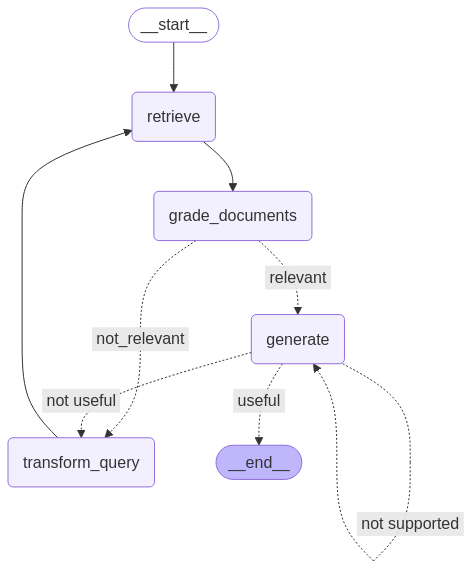

In [356]:
Image(
    app.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API
    )
)

### AI Agent with Fine-Tuned Model (Summarization). Summarization used after the answer generation. It will generate a summary of the answer

In [357]:
# new workflow for summarization
workflow2 = StateGraph(GraphState)

# nodes for workflow
workflow2.add_node("retrieve", retrieve) # retrieve
workflow2.add_node("grade_documents", grade_documents) # grade documents
workflow2.add_node("generate", generate) # generatae
workflow2.add_node("transform_query", transform_query) # transform_query
workflow2.add_node("summary", summary)  # summary 

# graph on the new workflow
workflow2.add_edge(START, "retrieve")
workflow2.add_edge("retrieve", "grade_documents")
workflow2.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "not_relevant": "transform_query",
        "relevant": "generate",
    },
)
workflow2.add_edge("transform_query", "retrieve")
workflow2.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": "summary",  
        "not useful": "transform_query",
    },
)
workflow2.add_edge("summary", END)  

# Compile
app2 = workflow2.compile()

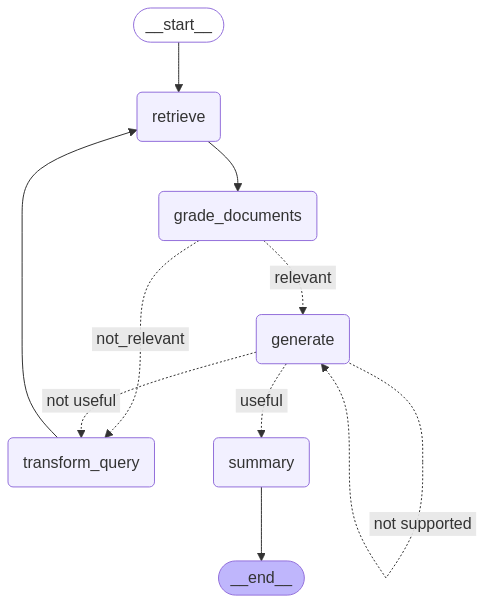

In [358]:
Image(
    app2.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API
    )
)

### AI Agent with Fine-Tuned model (Summarization) - Summarize the documents before generating the answer

In [359]:
workflow3 = StateGraph(GraphState)

# Define nodes
workflow3.add_node("retrieve", retrieve)
workflow3.add_node("grade_documents", grade_documents)
workflow3.add_node("summarize_documents", summarize_documents)
workflow3.add_node("generate", generate_with_summarized_docs)
workflow3.add_node("transform_query", transform_query)

# Build graph
workflow3.add_edge(START, "retrieve")
workflow3.add_edge("retrieve", "grade_documents")
workflow3.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "not_relevant": "transform_query",
        "relevant": "summarize_documents",  # Send to document summarization first
    },
)
workflow3.add_edge("summarize_documents", "generate")  # Then to generation
workflow3.add_edge("transform_query", "retrieve")
workflow3.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,  # End directly after generation if useful
        "not useful": "transform_query",
    },
)

# Compile
app3 = workflow3.compile()

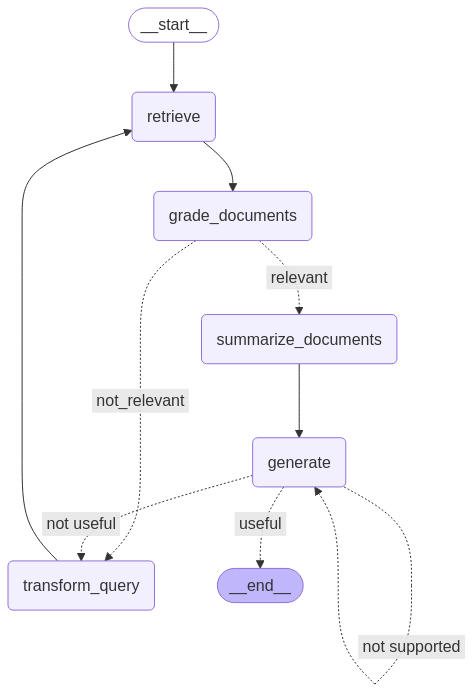

In [360]:
Image(
    app3.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API
    )
)

## Sample Output

In [361]:
def base_llm(question):
    ans = llm.invoke(question)
    return ans.content

def base_rags(question):
    ans = rag_chain.invoke(question)
    return ans

def ai_agent_1(question):
    inputs = {"question": question}
    runconfig = {"recursion_limit": 50}
    
    # Run the query and get the final output
    final_output = None
    for output in app.stream(inputs, config=runconfig):
        final_output = output
    
    # Return the generated answer if available
    if final_output and 'generate' in final_output and 'generation' in final_output['generate']:
        return final_output['generate']['generation']
    else:
        return "I don't have enough information to answer that question."
    
def ai_agent_2(question):
    inputs = {"question": question}
    runconfig = {"recursion_limit": 50}
    
    # Run the query and get the final output
    final_output = None
    for output in app2.stream(inputs, config=runconfig):
        final_output = output
    
    # Return the generated answer if available
    if final_output and 'summary' in final_output and 'summarized' in final_output['summary']:
        return final_output['summary']['summarized']
    else:
        return "I don't have enough information to answer that question."
    
def ai_agent_3(question):
    inputs = {"question": question}
    runconfig = {"recursion_limit": 50}
    
    # Run the query and get the final output
    final_output = None
    for output in app3.stream(inputs, config=runconfig):
        final_output = output
    
    # Return the generated answer if available
    if final_output and 'generate' in final_output and 'generation' in final_output['generate']:
        return final_output['generate']['generation']
    else:
        return "I don't have enough information to answer that question."

In [363]:
prompt = "What is happening to the Crypto market right now? Are there any news related to bitcoins and what are the implications of it?"
print(f"Base LLM: \n{base_llm(prompt)}\n")
print(f"Base RAGs: \n{base_rags(prompt)}\n")
print(f"Base Advanced RAGs with Agents (without fine-tuning model): \n{ai_agent_1(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the generated answer): \n{ai_agent_2(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the retrieved documents): \n{ai_agent_3(prompt)}\n")

Base LLM: 
As of my last update in October 2023, I don't have real-time data or updates on the current state of the cryptocurrency market, including Bitcoin. However, I can provide some general insights into how to assess the market and what types of news typically impact Bitcoin and other cryptocurrencies.

1. **Market Trends**: The cryptocurrency market is known for its volatility. Prices can fluctuate significantly based on market sentiment, regulatory news, technological developments, and macroeconomic factors.

2. **Regulatory News**: Announcements from governments or regulatory bodies regarding cryptocurrency regulations can have a substantial impact on the market. Positive regulations can lead to price increases, while negative news can cause declines.

3. **Adoption and Institutional Interest**: News about major companies or financial institutions adopting Bitcoin or other cryptocurrencies can boost market confidence and drive prices up. Conversely, reports of major sell-offs o

In [364]:
prompt = "Anything happening to microstraregy company and stock?"
print(f"Base LLM: \n{base_llm(prompt)}\n")
print(f"Base RAGs: \n{base_rags(prompt)}\n")
print(f"Base Advanced RAGs with Agents (without fine-tuning model): \n{ai_agent_1(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the generated answer): \n{ai_agent_2(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the retrieved documents): \n{ai_agent_3(prompt)}\n")

Base LLM: 
As of my last update in October 2023, MicroStrategy has been known for its significant investments in Bitcoin and its strategy of using Bitcoin as a primary treasury reserve asset. The company's stock, traded under the ticker MSTR, has often been influenced by the price movements of Bitcoin, as well as its own business performance and strategic decisions.

For the latest news and stock performance, I recommend checking financial news websites, stock market platforms, or MicroStrategy's official communications. If you're looking for specific recent developments or trends, please let me know!

Base RAGs: 
MicroStrategy's shares recently rose after the announcement that it will join the Nasdaq-100 index, but they later gave back some gains. The stock is currently down about 5% after a significant increase of 547% this year, largely driven by the rise in Bitcoin prices, which are around $105,900.66. The index inclusion takes effect on December 23.

Base Advanced RAGs with Agents

In [366]:
prompt = "Any problem with the US Stock market right now?"
print(f"Base LLM: \n{base_llm(prompt)}\n")
print(f"Base RAGs: \n{base_rags(prompt)}\n")
print(f"Base Advanced RAGs with Agents (without fine-tuning model): \n{ai_agent_1(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the generated answer): \n{ai_agent_2(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the retrieved documents): \n{ai_agent_3(prompt)}\n")

Base LLM: 
As of my last update in October 2023, I don't have real-time data or current market conditions. However, stock market issues can arise from various factors, including economic indicators, interest rates, inflation, geopolitical events, corporate earnings reports, and investor sentiment.

To get the most accurate and up-to-date information on the US stock market, I recommend checking financial news websites, stock market analysis platforms, or consulting with a financial advisor. They can provide insights into current trends, potential risks, and market performance.

Base RAGs: 
Yes, there are problems with the US stock market right now. The S&P 500 and Nasdaq Composite both closed down 0.6%, and there is significant uncertainty as investors await interest rate decisions from the US Federal Reserve and other central banks, leading to hesitancy and selling pressure.

Base Advanced RAGs with Agents (without fine-tuning model): 
1. The S&P 500 closed down 0.6% at 6,052.85.
2. Th

In [367]:
prompt = "How was the employment rate right now? Is the job market still in a tough condition?"
print(f"Base LLM: \n{base_llm(prompt)}\n")
print(f"Base RAGs: \n{base_rags(prompt)}\n")
print(f"Base Advanced RAGs with Agents (without fine-tuning model): \n{ai_agent_1(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the generated answer): \n{ai_agent_2(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the retrieved documents): \n{ai_agent_3(prompt)}\n")

Base LLM: 
I don't have real-time data access, so I can't provide the current employment rate or the state of the job market as of now. However, as of my last update in October 2023, the job market was showing signs of recovery in many regions, with varying conditions depending on the industry and location. 

To get the most accurate and up-to-date information on the employment rate and job market conditions, I recommend checking reliable sources such as government labor statistics, economic reports, or news articles from reputable financial news outlets.

Base RAGs: 
The employment rate is steady, with the unemployment rate unchanged at 4.3%. While some sectors are still tough for job seekers, others continue to offer opportunities. Overall, the job market remains tight, with high wage levels and persistent wage growth.

Base Advanced RAGs with Agents (without fine-tuning model): 
1. The unemployment rate remained unchanged at 4.3% in the three months to October. 

2. Employment is ov

In [370]:
prompt = "Any problem with Facebook recently? Do you think Facebook will survive while there is a problem and why?"
print(f"Base LLM: \n{base_llm(prompt)}\n")
print(f"Base RAGs: \n{base_rags(prompt)}\n")
print(f"Base Advanced RAGs with Agents (without fine-tuning model): \n{ai_agent_1(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the generated answer): \n{ai_agent_2(prompt)}\n")
print(f"Base Advanced RAGs with Agents (with fine-tuning model as the summarizer of the retrieved documents): \n{ai_agent_3(prompt)}\n")

Base LLM: 
As of my last update in October 2023, Facebook (now part of Meta Platforms, Inc.) has faced various challenges, including issues related to privacy, misinformation, regulatory scrutiny, and competition from other social media platforms. These challenges have led to public criticism and calls for greater regulation.

Despite these issues, Facebook has a large user base and significant resources, which contribute to its resilience. The platform has been adapting by investing in new technologies, such as virtual and augmented reality, and focusing on community building and user engagement. Additionally, its integration with other services and platforms under the Meta umbrella, like Instagram and WhatsApp, helps maintain its relevance.

While challenges remain, Facebook's ability to innovate and adapt, along with its vast user base, suggests that it is likely to survive in the long term. However, its future will depend on how effectively it addresses ongoing issues and navigates